In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg11, resnet18
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

def create_dataset(data_home, batch_size=32, do_train=True):
    """
    创建CIFAR-10数据集供训练或测试使用
    """
    # 定义数据变换
    transform_list = []
    if do_train:
        transform_list += [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5)
        ]
    
    transform_list += [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ]
    
    transform = transforms.Compose(transform_list)
    
    # 加载数据集
    if do_train:
        dataset = torchvision.datasets.CIFAR10(
            root=data_home, train=True, download=True, transform=transform
        )
    else:
        dataset = torchvision.datasets.CIFAR10(
            root=data_home, train=False, download=True, transform=transform
        )
    
    # 创建数据加载器
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=do_train, num_workers=4, drop_last=True
    )
    
    return dataloader

class StepLossAccTracker:
    """
    用于跟踪训练过程中的损失和准确率
    """
    def __init__(self):
        self.steps_loss = {"step": [], "loss_value": []}
        self.steps_eval = {"step": [], "acc": []}
    
    def add_loss(self, step, loss):
        self.steps_loss["step"].append(step)
        self.steps_loss["loss_value"].append(loss)
    
    def add_acc(self, step, acc):
        self.steps_eval["step"].append(step)
        self.steps_eval["acc"].append(acc)

def evaluate_model(model, test_loader):
    """
    评估模型准确率
    """
    model.eval()
    correct = 0
    total = 0
    precision_total = 0
    recall_total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # 简化版的精确率和召回率（多分类问题中不太适用，这里仅作示例）
            for i in range(10):  # 10个类别
                pred_i = predicted == i
                labels_i = labels == i
                tp = (pred_i & labels_i).sum().item()
                pred_total = pred_i.sum().item()
                actual_total = labels_i.sum().item()
                
                if pred_total > 0:
                    precision_total += tp / pred_total
                if actual_total > 0:
                    recall_total += tp / actual_total
    
    accuracy = correct / total
    precision = precision_total / 10  # 简化，取平均
    recall = recall_total / 10  # 简化，取平均
    
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
    }

def train(net_type, learning_rate, epoch_size):
    start_execution_time = time.time()
    
    # 设置网络结构
    if net_type == "vgg11":
        net = vgg11(weights=None)
        # 修改最后一层以适应CIFAR-10的10个类别
        net.classifier[6] = nn.Linear(4096, 10)
    elif net_type == 'resnet18':
        net = resnet18(weights=None)
        # 修改最后一层以适应CIFAR-10的10个类别
        net.fc = nn.Linear(net.fc.in_features, 10)
    else:
        raise ValueError(f"不支持的网络类型: {net_type}")
    
    net = net.to(device)
    
    # 设置损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    # 设置数据集
    data_dir = "./data"
    train_loader = create_dataset(data_dir, batch_size=32, do_train=True)
    test_loader = create_dataset(data_dir, batch_size=32, do_train=False)
    
    # 创建模型保存目录
    model_path = f'./models/{net_type}/{learning_rate}/'
    os.makedirs(model_path, exist_ok=True)
    
    # 设置记录器
    tracker = StepLossAccTracker()
    
    # 开始训练
    start_train_time = time.time()
    print("Training Start:")
    global_step = 0
    
    for epoch in range(epoch_size):
        net.train()
        running_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 梯度清零
            optimizer.zero_grad()
            
            # 前向传播、计算损失、反向传播、优化
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            global_step += 1
            
            # 每10步记录一次损失
            if global_step % 10 == 0:
                tracker.add_loss(global_step, loss.item())
            
            # 每100步评估一次准确率
            if global_step % 100 == 0:
                results = evaluate_model(net, test_loader)
                tracker.add_acc(global_step, results["Accuracy"])
                net.train()  # 恢复训练模式
                
                print(f"Epoch: {epoch+1}, Step: {global_step}, Loss: {loss.item():.4f}, Acc: {results['Accuracy']:.4f}")
        
        print(f"Epoch {epoch+1} complete. Average loss: {running_loss/len(train_loader):.4f}")
    
    end_train_time = time.time()
    
    # 保存模型
    torch.save(net.state_dict(), f"{model_path}/final_model.pth")
    
    # 最终评估
    results = evaluate_model(net, test_loader)
    print("Final results:", results)
    
    end_execution_time = time.time()
    print(f"Training time: {end_train_time - start_train_time:.6f} s")
    print(f"Total execution time: {end_execution_time - start_execution_time:.6f} s")
    
    # 绘制损失和准确率曲线
    plt.figure(figsize=(15, 5))
    
    # 损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(tracker.steps_loss["step"], tracker.steps_loss["loss_value"], color="red")
    plt.xlabel("Steps")
    plt.ylabel("Loss Value")
    plt.title("Model Loss Value")
    
    # 准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(tracker.steps_eval["step"], tracker.steps_eval["acc"], color="blue")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy")
    
    plt.show()
    
    return results

# 调用方式：
# train("resnet18", 1e-3, 3)
# train("vgg11", 1e-3, 3)

Using cpu


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training Start:
Epoch: 1, Step: 100, Loss: 2.1122, Acc: 0.1369
Epoch: 1, Step: 200, Loss: 2.1526, Acc: 0.1136
Epoch: 1, Step: 300, Loss: 2.1772, Acc: 0.0999
Epoch: 1, Step: 400, Loss: 1.9652, Acc: 0.0901
Epoch: 1, Step: 500, Loss: 1.7750, Acc: 0.1360
Epoch: 1, Step: 600, Loss: 1.5859, Acc: 0.1534
Epoch: 1, Step: 700, Loss: 1.7146, Acc: 0.1531
Epoch: 1, Step: 800, Loss: 1.7405, Acc: 0.1543
Epoch: 1, Step: 900, Loss: 1.5760, Acc: 0.1761
Epoch: 1, Step: 1000, Loss: 1.6840, Acc: 0.1593
Epoch: 1, Step: 1100, Loss: 1.6516, Acc: 0.1665
Epoch: 1, Step: 1200, Loss: 1.2765, Acc: 0.1818
Epoch: 1, Step: 1300, Loss: 1.6044, Acc: 0.1658
Epoch: 1, Step: 1400, Loss: 1.3269, Acc: 0.1722
Epoch: 1, Step: 1500, Loss: 1.1185, Acc: 0.1770
Epoch 1 complete. Average loss: 1.7147
Epoch: 2, Step: 1600, Loss: 1.3947, Acc: 0.1764
Epoch: 2, Step: 1700, Loss: 0.9843, Acc: 0.1728
Epoch: 2, Step: 1800, Loss: 1.3447, Acc: 0.1697
E

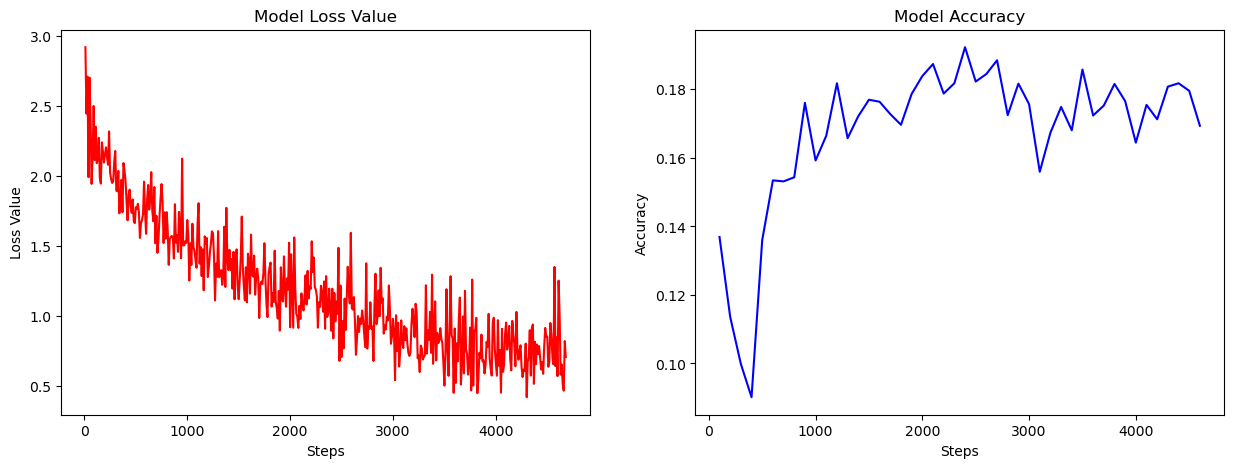

{'Accuracy': 0.16927083333333334,
 'Precision': 40.5258899678752,
 'Recall': 52.020238095238014}

In [2]:
train("resnet18", 1e-2, 3)

Files already downloaded and verified
Files already downloaded and verified
Training Start:
Epoch: 1, Step: 100, Loss: 2.0687, Acc: 0.1473
Epoch: 1, Step: 200, Loss: 1.5844, Acc: 0.1331
Epoch: 1, Step: 300, Loss: 1.4959, Acc: 0.1464
Epoch: 1, Step: 400, Loss: 1.4308, Acc: 0.1546
Epoch: 1, Step: 500, Loss: 1.3249, Acc: 0.1649
Epoch: 1, Step: 600, Loss: 1.3796, Acc: 0.1309
Epoch: 1, Step: 700, Loss: 1.3001, Acc: 0.1525
Epoch: 1, Step: 800, Loss: 1.1828, Acc: 0.1447
Epoch: 1, Step: 900, Loss: 1.3683, Acc: 0.1226
Epoch: 1, Step: 1000, Loss: 1.0802, Acc: 0.1304
Epoch: 1, Step: 1100, Loss: 1.5688, Acc: 0.1252
Epoch: 1, Step: 1200, Loss: 0.8194, Acc: 0.1012
Epoch: 1, Step: 1300, Loss: 1.2511, Acc: 0.1096
Epoch: 1, Step: 1400, Loss: 1.4299, Acc: 0.1076
Epoch: 1, Step: 1500, Loss: 0.9441, Acc: 0.1284
Epoch 1 complete. Average loss: 1.3748
Epoch: 2, Step: 1600, Loss: 0.8943, Acc: 0.1482
Epoch: 2, Step: 1700, Loss: 1.5710, Acc: 0.1253
Epoch: 2, Step: 1800, Loss: 0.9073, Acc: 0.1353
Epoch: 2, Step

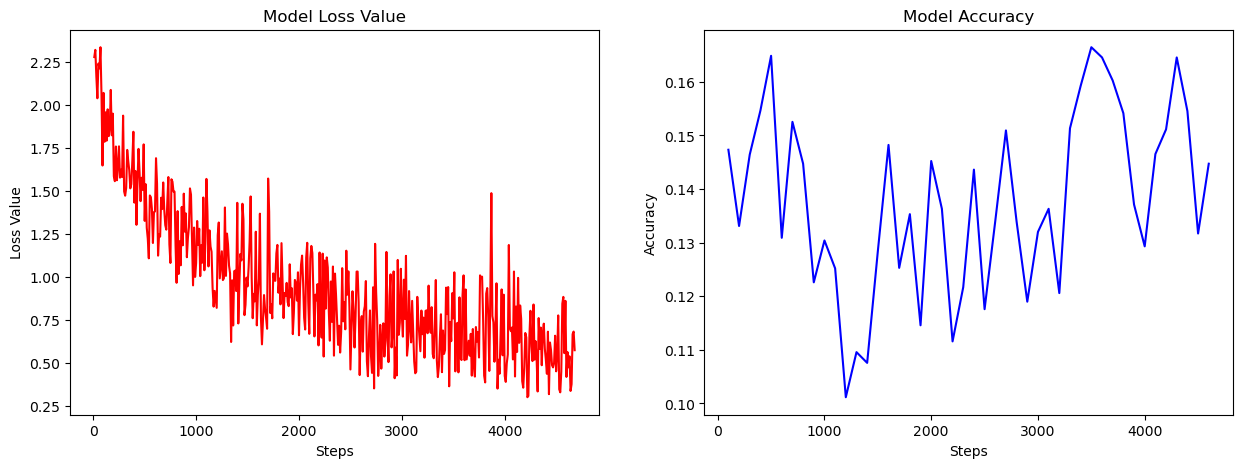

{'Accuracy': 0.11929086538461539,
 'Precision': 28.464717086319233,
 'Recall': 35.82873015873007}

In [3]:
train("resnet18", 1e-3, 3)

In [ ]:
train("resnet18", 1e-4, 3)

Files already downloaded and verified
Files already downloaded and verified
Training Start:
Epoch: 1, Step: 100, Loss: 1.7265, Acc: 0.1160
Epoch: 1, Step: 200, Loss: 1.3995, Acc: 0.1278
Epoch: 1, Step: 300, Loss: 1.4618, Acc: 0.1256
Epoch: 1, Step: 400, Loss: 1.4621, Acc: 0.1232
Epoch: 1, Step: 500, Loss: 1.3741, Acc: 0.1344
Epoch: 1, Step: 600, Loss: 0.9600, Acc: 0.1228
Epoch: 1, Step: 700, Loss: 1.3305, Acc: 0.1284
Epoch: 1, Step: 800, Loss: 1.0220, Acc: 0.1273
Epoch: 1, Step: 900, Loss: 1.0349, Acc: 0.1239
Epoch: 1, Step: 1000, Loss: 1.1612, Acc: 0.1241
Epoch: 1, Step: 1100, Loss: 1.0997, Acc: 0.1203
Epoch: 1, Step: 1200, Loss: 0.8264, Acc: 0.1066
Epoch: 1, Step: 1300, Loss: 1.0890, Acc: 0.1255
Epoch: 1, Step: 1400, Loss: 0.7511, Acc: 0.1246
Epoch: 1, Step: 1500, Loss: 0.8679, Acc: 0.1266
Epoch 1 complete. Average loss: 1.2465
Epoch: 2, Step: 1600, Loss: 0.9190, Acc: 0.1261
Epoch: 2, Step: 1700, Loss: 1.1373, Acc: 0.1332
Epoch: 2, Step: 1800, Loss: 1.0589, Acc: 0.1307
Epoch: 2, Step

In [ ]:
train("vgg11", 1e-2, 3)

Training Start:
epoch: 1 step: 100, loss is 2.3264453411102295
epoch: 1 step: 200, loss is 2.1675639152526855
epoch: 1 step: 300, loss is 2.1901485919952393
epoch: 1 step: 400, loss is 1.9398034811019897
epoch: 1 step: 500, loss is 1.6825275421142578
epoch: 1 step: 600, loss is 1.931849718093872
epoch: 1 step: 700, loss is 1.8038090467453003
epoch: 1 step: 800, loss is 2.297109365463257
epoch: 1 step: 900, loss is 1.6168993711471558
epoch: 1 step: 1000, loss is 1.6928359270095825
epoch: 1 step: 1100, loss is 1.8844062089920044
epoch: 1 step: 1200, loss is 1.637569546699524
epoch: 1 step: 1300, loss is 1.822930097579956
epoch: 1 step: 1400, loss is 1.7427934408187866
epoch: 1 step: 1500, loss is 1.6372464895248413
epoch: 2 step: 38, loss is 1.7824198007583618
epoch: 2 step: 138, loss is 1.7552905082702637
epoch: 2 step: 238, loss is 1.7517915964126587
epoch: 2 step: 338, loss is 1.6784957647323608
epoch: 2 step: 438, loss is 1.518843173980713
epoch: 2 step: 538, loss is 1.78827548027038

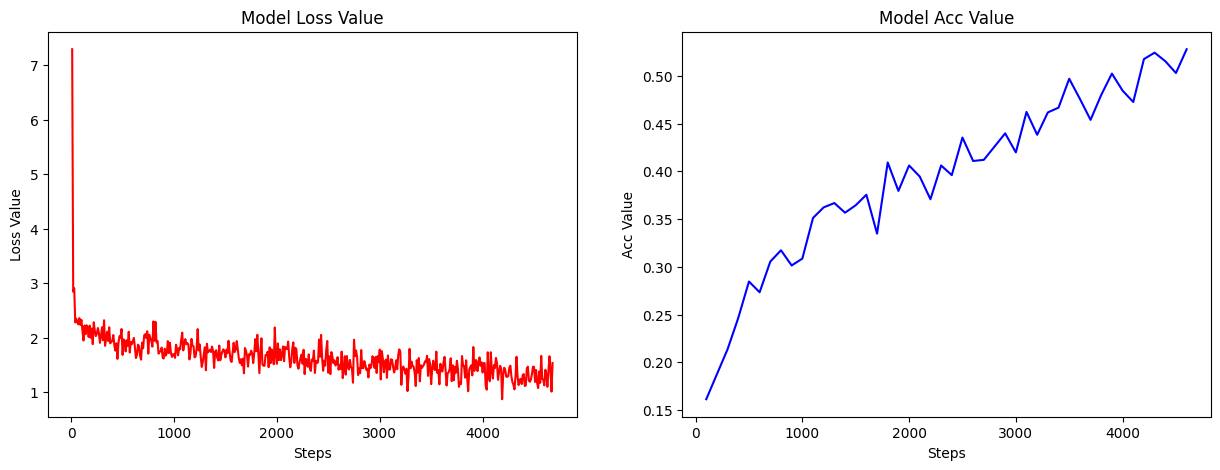

In [ ]:
train("vgg11", 1e-3, 3)

Training Start:
epoch: 1 step: 100, loss is 1.8462655544281006
epoch: 1 step: 200, loss is 1.641615867614746
epoch: 1 step: 300, loss is 1.6563605070114136
epoch: 1 step: 400, loss is 1.3034836053848267
epoch: 1 step: 500, loss is 1.5211988687515259
epoch: 1 step: 600, loss is 1.2519806623458862
epoch: 1 step: 700, loss is 1.2210382223129272
epoch: 1 step: 800, loss is 1.346051573753357
epoch: 1 step: 900, loss is 1.2114076614379883
epoch: 1 step: 1000, loss is 0.973449170589447
epoch: 1 step: 1100, loss is 0.8998945355415344
epoch: 1 step: 1200, loss is 1.0177589654922485
epoch: 1 step: 1300, loss is 1.1281229257583618
epoch: 1 step: 1400, loss is 0.5509196519851685
epoch: 1 step: 1500, loss is 0.8178381323814392
epoch: 2 step: 38, loss is 0.9733805060386658
epoch: 2 step: 138, loss is 1.3794587850570679
epoch: 2 step: 238, loss is 0.5560733675956726
epoch: 2 step: 338, loss is 1.1595048904418945
epoch: 2 step: 438, loss is 0.8121802806854248
epoch: 2 step: 538, loss is 1.001062870025

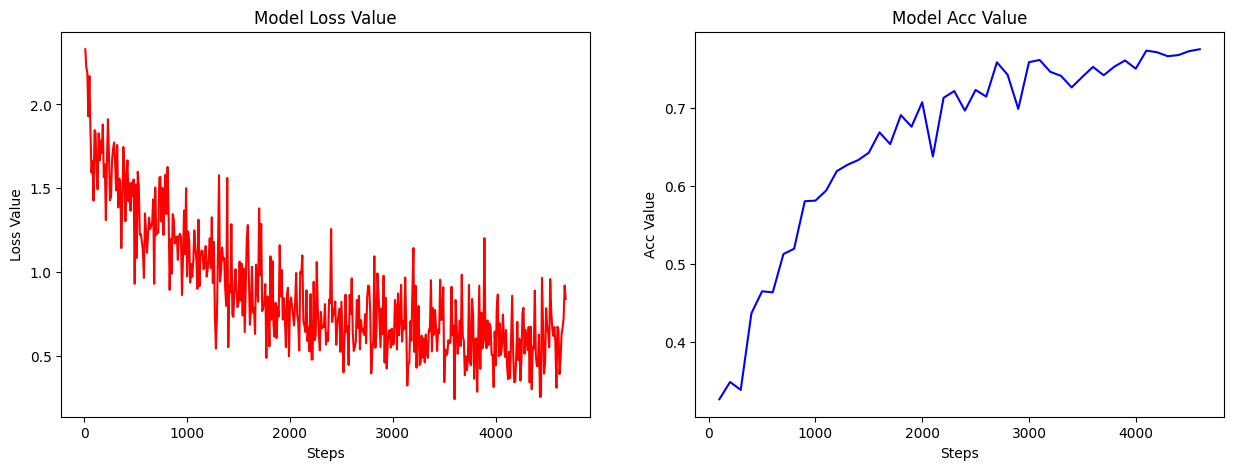

In [ ]:
train("vgg11", 1e-4, 3)